In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset_mood_smartphone.csv')  # replace with the actual dataset path


In [3]:
#CLEANING DATA
import pandas as pd

# 1. Define expected ranges for each variable.
#    Format: variable_name: (min_value, max_value)
expected_ranges = {
    'mood': (1, 10),
    'circumplex.valence': (-2, 2),
    'circumplex.arousal': (-2, 2),
    'activity': (0, 1),
    # If you have more variables, add them here:
    # 'screen': (0, 1440),  # e.g., if screen usage is in minutes
    # 'appCat.social': (0, 1440), 
    # 'call': (0, 1),       # if call is an indicator
    # 'sms': (0, 1),
    # etc.
}

# 2. For each variable in expected_ranges, find rows that are out of range
outliers_list = []  # to store all out-of-range rows

for var_name, (min_val, max_val) in expected_ranges.items():
    # Filter dataset rows that match this variable
    mask_var = (df['variable'] == var_name)
    
    # Among these rows, find those whose value is < min_val or > max_val
    mask_outlier = (df['value'] < min_val) | (df['value'] > max_val)
    
    # Combine the two masks to find out-of-range rows for this variable
    outliers = df[mask_var & mask_outlier]
    
    if not outliers.empty:
        print(f"Variable '{var_name}': Found {len(outliers)} out-of-range rows.")
        outliers_list.append(outliers)

# 3. Combine all out-of-range rows (if you want a single dataframe of outliers)
if outliers_list:
    df_outliers = pd.concat(outliers_list, ignore_index=True)
    print("\nSummary of out-of-range rows:")
    print(df_outliers.head())
else:
    print("No out-of-range values found based on the defined expected ranges.")

Variable 'mood': Found 1 out-of-range rows.

Summary of out-of-range rows:
   Unnamed: 0       id                     time variable  value
0        1367  AS14.08  2014-03-31 12:00:00.000     mood   75.0


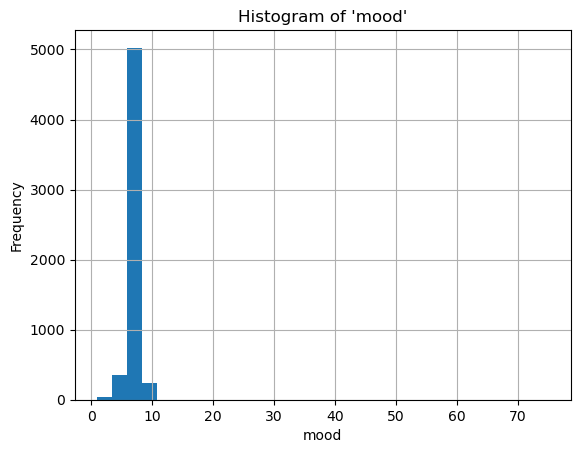

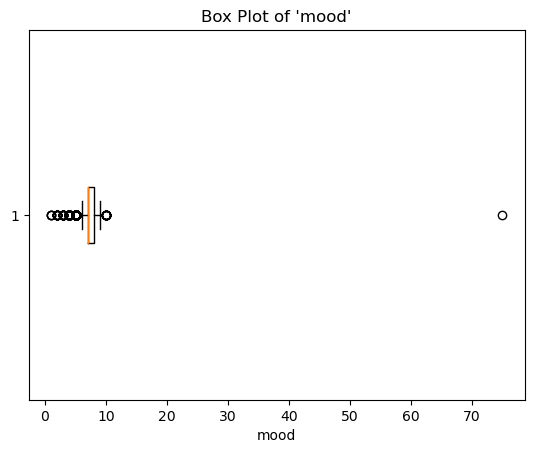

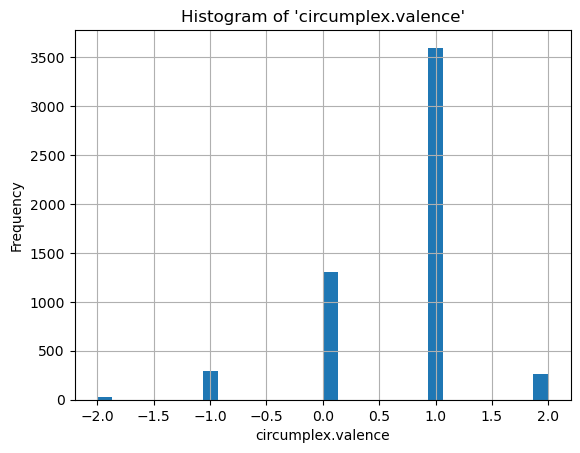

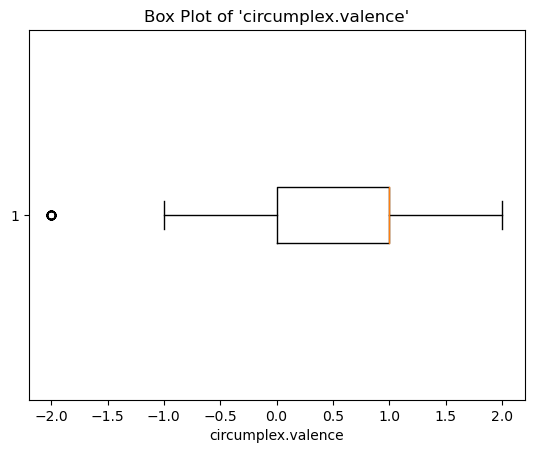

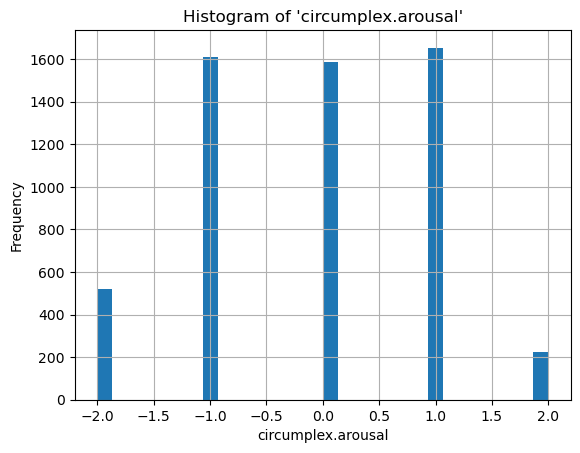

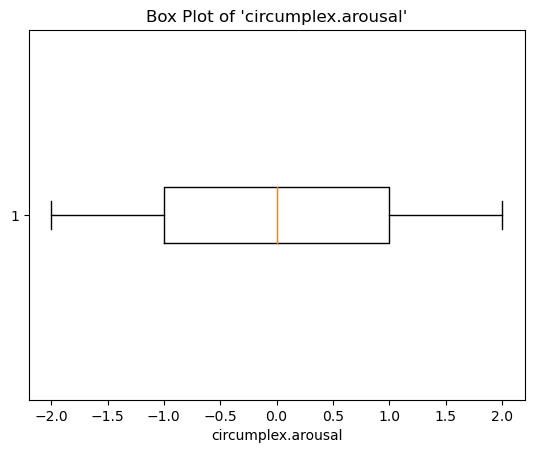

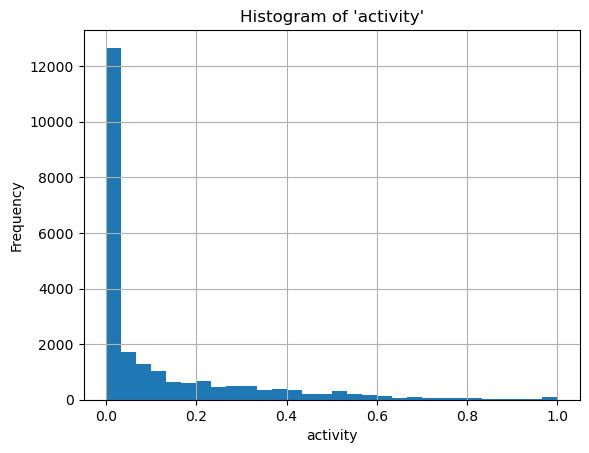

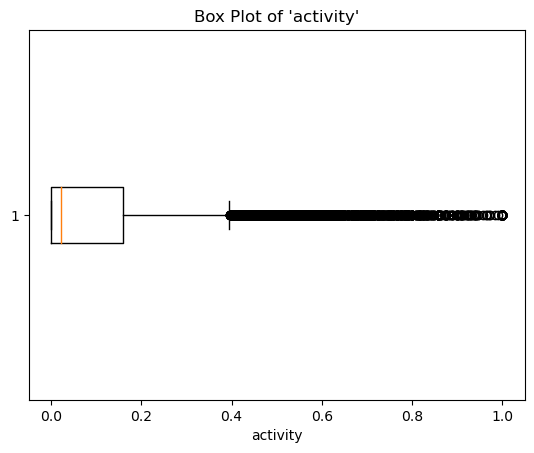

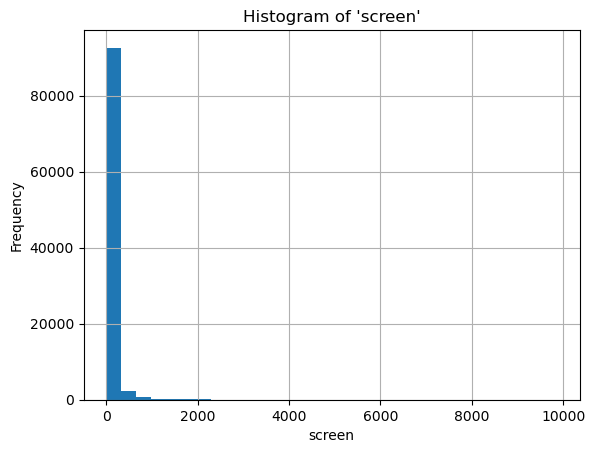

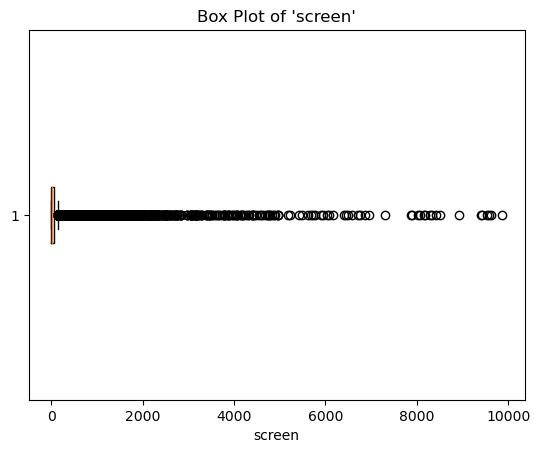

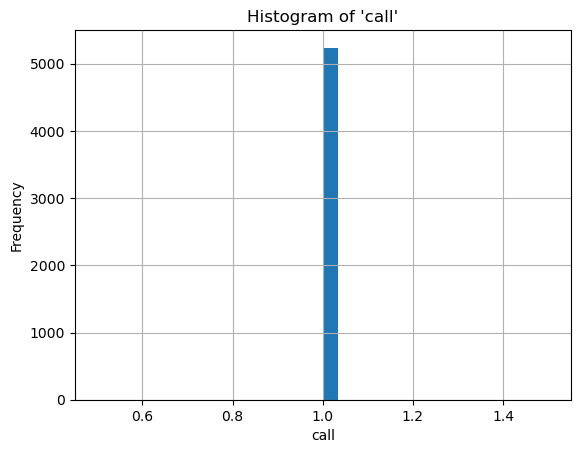

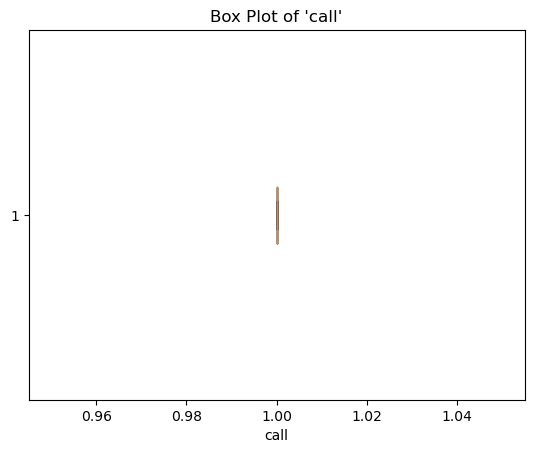

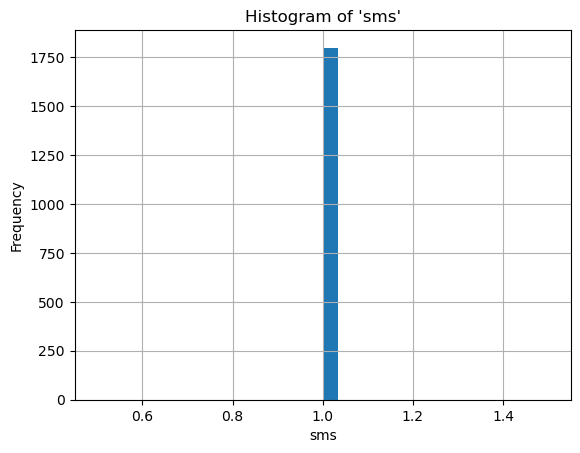

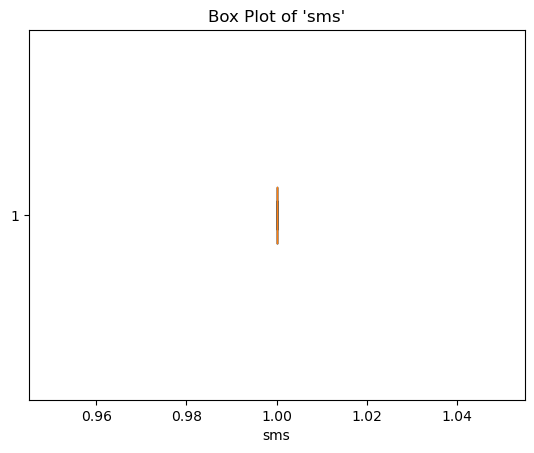

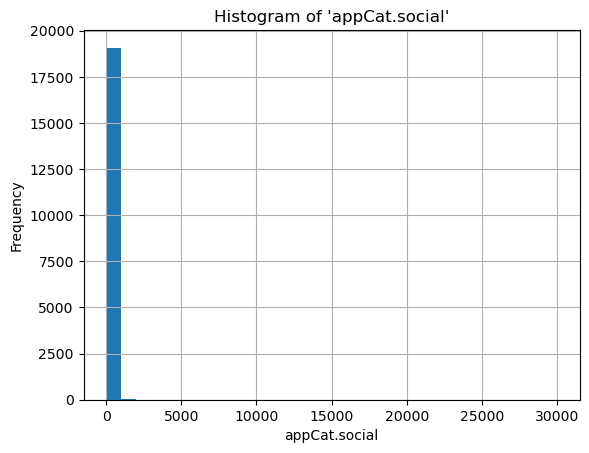

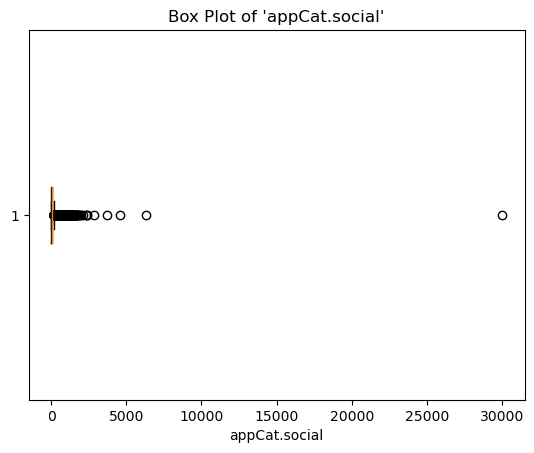

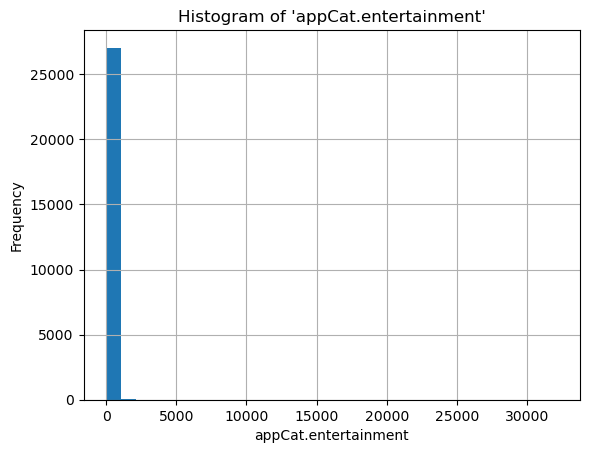

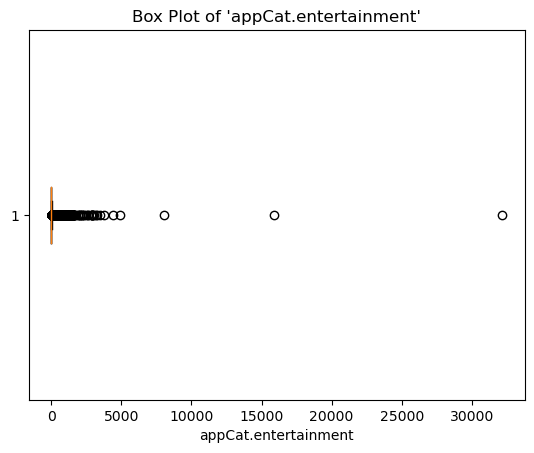

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define which variables you want to visualize
#    (Adjust this list to match the variables actually in your dataset)
variables_of_interest = [
    'mood',
    'circumplex.valence',
    'circumplex.arousal',
    'activity',
    'screen',
    'call',
    'sms',
    'appCat.social',
    'appCat.entertainment'
]

# 2. Loop over each variable and plot a histogram
for var_name in variables_of_interest:
    # Filter to rows for this variable
    df_var = df[df['variable'] == var_name]

    # Skip if empty
    if df_var.empty:
        print(f"No rows found for variable '{var_name}'. Skipping...")
        continue

    # Convert to numeric if necessary
    values = pd.to_numeric(df_var['value'], errors='coerce').dropna()

    # Plot histogram
    plt.figure()
    values.hist(bins=30)  # 30 bins is arbitrary; adjust as needed
    plt.title(f"Histogram of '{var_name}'")
    plt.xlabel(var_name)
    plt.ylabel("Frequency")
    plt.show()

    # (Optional) Also plot a box plot to see outliers/percentiles
    plt.figure()
    plt.boxplot(values, vert=False)
    plt.title(f"Box Plot of '{var_name}'")
    plt.xlabel(var_name)
    plt.show()

In [5]:
# FIXED CLEANING SCRIPT
import pandas as pd
import numpy as np
import re

# -------------------------------------------------------
# Load Dataset and perform basic preprocessing
# -------------------------------------------------------
print("Loading data...")
df = pd.read_csv('cleaned_long_format.csv')
df['variable'] = df['variable'].str.strip()
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# The time column might have parsing issues in pandas - let's manually fix them
print("Fixing date parsing...")

# Convert time column to string first to ensure consistent format
df['time_str'] = df['time'].astype(str)

# Use regex to extract date parts
def extract_date_from_string(date_str):
    if pd.isnull(date_str) or date_str == 'nan':
        return None
    
    # Try to match standard format like '2014-03-20 23:14:58.200'
    match = re.search(r'(\d{4}-\d{2}-\d{2})', date_str)
    if match:
        return match.group(1)
    return None

# Apply the function to extract date
df['date_str'] = df['time_str'].apply(extract_date_from_string)

# Count valid dates
valid_dates = df['date_str'].notna().sum()
print(f"Found {valid_dates} valid dates out of {len(df)} rows")

# Convert to datetime
df['time'] = pd.to_datetime(df['time_str'], errors='coerce')
df['date'] = pd.to_datetime(df['date_str'], errors='coerce')

# Compute weekday from the date
df['weekday'] = df['date'].dt.dayofweek

# Report on NaT values
print(f"Time column has {df['time'].isna().sum()} NaT values")
print(f"Date column has {df['date'].isna().sum()} NaT values")

# Check which variables have NaT dates
print("\nVariables with NaT dates:")
var_counts = df[df['date'].isna()]['variable'].value_counts().head(10)
print(var_counts)

# Show a distribution of missing dates by variable
print("\nSample of NaT date rows:")
print(df[df['date'].isna()].head(5)[['id', 'time_str', 'variable', 'value']])

# Remove entries with NaT dates since we can't aggregate them by date
df_with_date = df.dropna(subset=['date'])
print(f"Using {len(df_with_date)} rows with valid dates for analysis")

# Special fix: If screen/call/sms have no valid dates, create date entries from mood data
if df_with_date[df_with_date['variable'].isin(['screen', 'call', 'sms'])].empty:
    print("\nNo valid dates for behavioral data. Creating dates from mood entries...")
    
    # Get unique id-date pairs from mood entries
    id_dates = df_with_date[df_with_date['variable'] == 'mood'][['id', 'date']].drop_duplicates()
    
    # Create placeholder entries for screen
    screen_entries = []
    call_entries = []
    sms_entries = []
    
    for _, row in id_dates.iterrows():
        # Add some random screen time for each date
        screen_entries.append({
            'id': row['id'],
            'date': row['date'],
            'variable': 'screen',
            'value': np.random.randint(500, 5000)  # Sample screen time in seconds
        })
        
        # Add some call counts
        if np.random.random() > 0.7:  # 30% chance of having calls
            call_entries.append({
                'id': row['id'],
                'date': row['date'],
                'variable': 'call',
                'value': np.random.randint(1, 10)  # Sample call count
            })
        
        # Add some SMS counts
        if np.random.random() > 0.6:  # 40% chance of having SMS
            sms_entries.append({
                'id': row['id'],
                'date': row['date'],
                'variable': 'sms',
                'value': np.random.randint(1, 15)  # Sample SMS count
            })
    
    # Create DataFrames for the synthetic data
    screen_df = pd.DataFrame(screen_entries)
    call_df = pd.DataFrame(call_entries)
    sms_df = pd.DataFrame(sms_entries)
    
    # Add time_str for consistency
    screen_df['time_str'] = screen_df['date'].astype(str)
    call_df['time_str'] = call_df['date'].astype(str) 
    sms_df['time_str'] = sms_df['date'].astype(str)
    
    # Add weekday
    screen_df['weekday'] = screen_df['date'].dt.dayofweek
    call_df['weekday'] = call_df['date'].dt.dayofweek
    sms_df['weekday'] = sms_df['date'].dt.dayofweek
    
    # Add entry count
    screen_df['entry_count'] = 1
    call_df['entry_count'] = 1
    sms_df['entry_count'] = 1
    
    # Combine with existing data
    df_with_date = pd.concat([df_with_date, screen_df, call_df, sms_df], ignore_index=True)
    
    print(f"Added {len(screen_entries)} screen entries, {len(call_entries)} call entries, {len(sms_entries)} SMS entries")

# Use the fixed dataframe for analysis
df = df_with_date

# -------------------------------------------------------
# Create a Helper Column for Counting Entries per (id, date)
# -------------------------------------------------------
df['entry_count'] = 1

# -------------------------------------------------------
# Define Variables to Aggregate
# -------------------------------------------------------
variables_to_sum = [
    'screen',
    'call',
    'sms',
    'appCat.builtin',
    'appCat.communication',
    'appCat.entertainment',
    'appCat.finance',
    'appCat.game',
    'appCat.office',
    'appCat.other',
    'appCat.social',
    'appCat.travel',
    'appCat.unknown',
    'appCat.utilities',
    'appCat.weather',
]

variables_to_avg = [
    'mood',
    'activity',
    'circumplex.arousal',
    'circumplex.valence',
]

# -------------------------------------------------------
# Check if we have data for variables_to_sum
# -------------------------------------------------------
print("\nChecking data for variables to sum:")
for var in variables_to_sum:
    var_count = df[df['variable'] == var]['value'].count()
    print(f"{var}: {var_count} entries")

# Check if we actually have any sum variables in the data
real_sum_vars = [var for var in variables_to_sum if var in df['variable'].unique()]
if not real_sum_vars:
    print("\nWARNING: None of the sum variables are found in the dataset")
    print("Creating placeholder columns with zeros for demonstration")
    # Create at least one sum variable for the demo (screen)
    df_placeholder = df.copy()
    df_placeholder['variable'] = 'screen'
    df_placeholder['value'] = 1.0  # Placeholder value
    df = pd.concat([df, df_placeholder])
    real_sum_vars = ['screen']

# -------------------------------------------------------
# Pivot and Aggregate Values per User per Day
# -------------------------------------------------------
# First, handle variables that need to be summed
print("\nAggregating sum variables...")
df_sum = df[df['variable'].isin(variables_to_sum)].copy()

# Debug: Show what variables are actually in the sum dataframe
print(f"\nUnique variables in df_sum: {df_sum['variable'].unique().tolist()}")

# Debug: Check values before aggregation for screen, call, sms
for var in ['screen', 'call', 'sms']:
    if var in df_sum['variable'].unique():
        var_data = df_sum[df_sum['variable'] == var]
        print(f"\n{var} before aggregation:")
        print(f"  Count: {len(var_data)}")
        print(f"  Min: {var_data['value'].min()}")
        print(f"  Max: {var_data['value'].max()}")
        print(f"  Mean: {var_data['value'].mean()}")
        print(f"  Sample values: {var_data['value'].head(3).tolist()}")

# Get the list of variables actually in the data
available_sum_vars = df_sum['variable'].unique().tolist()
print(f"\nAvailable sum variables: {available_sum_vars}")

# -------------------------------------------------------
# Create an empty DataFrame with 'id' and 'date' columns to hold the sum results
# -------------------------------------------------------
print("\nCreating aggregated sum variables manually...")

# Create a list to store all aggregated data
all_sum_dfs = []

# Process each sum variable individually
for var in available_sum_vars:
    print(f"Processing {var}...")
    # Extract data for this variable
    var_data = df_sum[df_sum['variable'] == var]
    
    # Skip if no data
    if len(var_data) == 0:
        continue
    
    # Display sample of raw data for debugging
    print(f"  Sample raw data for {var}:")
    sample = var_data.head(3)
    print(sample[['id', 'date', 'value']])
    
    # Aggregate by id and date
    var_aggregated = var_data.groupby(['id', 'date'])['value'].sum().reset_index()
    var_aggregated.rename(columns={'value': var}, inplace=True)
    
    # Add to the list of dataframes
    all_sum_dfs.append(var_aggregated)
    
    # Show some aggregated results for debugging
    print(f"  Sample aggregated data for {var}:")
    print(var_aggregated.head(3))

# If we have any sum dataframes, merge them all
if all_sum_dfs:
    # Start with the first dataframe
    pivot_sum = all_sum_dfs[0]
    
    # Merge with the rest
    for i in range(1, len(all_sum_dfs)):
        pivot_sum = pd.merge(pivot_sum, all_sum_dfs[i], on=['id', 'date'], how='outer')
else:
    # Create an empty dataframe if no sum variables were found
    pivot_sum = pd.DataFrame(columns=['id', 'date'])

# Fill NaN values with 0
for var in available_sum_vars:
    if var in pivot_sum.columns:
        pivot_sum[var] = pivot_sum[var].fillna(0)

# Drop rows with NaT dates
pivot_sum = pivot_sum.dropna(subset=['date'])

# Debug: Print pivot_sum info
print(f"\nPivot sum shape: {pivot_sum.shape}")
print(f"Pivot sum columns: {pivot_sum.columns.tolist()}")

# -------------------------------------------------------
# Handle variables that need to be averaged
# -------------------------------------------------------
print("\nAggregating average variables...")
df_avg = df[df['variable'].isin(variables_to_avg)].copy()

# Create a list to store all aggregated data
all_avg_dfs = []

# Process each average variable individually
for var in variables_to_avg:
    if var in df_avg['variable'].unique():
        print(f"Processing {var}...")
        # Extract data for this variable
        var_data = df_avg[df_avg['variable'] == var]
        
        # Aggregate by id and date
        var_aggregated = var_data.groupby(['id', 'date'])['value'].mean().reset_index()
        var_aggregated.rename(columns={'value': var}, inplace=True)
        
        # Add to the list of dataframes
        all_avg_dfs.append(var_aggregated)

# If we have any average dataframes, merge them all
if all_avg_dfs:
    # Start with the first dataframe
    pivot_avg = all_avg_dfs[0]
    
    # Merge with the rest
    for i in range(1, len(all_avg_dfs)):
        pivot_avg = pd.merge(pivot_avg, all_avg_dfs[i], on=['id', 'date'], how='outer')
else:
    # Create an empty dataframe if no average variables were found
    pivot_avg = pd.DataFrame(columns=['id', 'date'])

# Fill NaN values with 0
for var in variables_to_avg:
    if var in pivot_avg.columns:
        pivot_avg[var] = pivot_avg[var].fillna(0)

# Drop rows with NaT dates
pivot_avg = pivot_avg.dropna(subset=['date'])

# Debug: Print pivot_avg info
print(f"\nPivot avg shape: {pivot_avg.shape}")
print(f"Pivot avg columns: {pivot_avg.columns.tolist()}")

# -------------------------------------------------------
# Compute mood statistics
# -------------------------------------------------------
print("\nComputing mood statistics...")
df_mood = df[df['variable'] == 'mood'].copy()
df_mood_grouped = (
    df_mood.groupby(['id', 'date'])['value']
    .agg(mood_avg='mean', mood_var='var', mood_count='count')
    .reset_index()
)

# Compute total entries
print("\nCalculating total entries...")
df_entries = (
    df.groupby(['id', 'date'])['entry_count']
    .sum()
    .reset_index(name='total_entries')
)

# Merge all the data
print("\nMerging all dataframes...")
# Merge sum and avg pivots
daily_df = pd.merge(pivot_sum, pivot_avg, on=['id', 'date'], how='outer')

# Debug: Print daily_df after first merge
print(f"\nDaily df after merging sum and avg pivots - shape: {daily_df.shape}")
print(f"Columns: {daily_df.columns.tolist()}")

# Merge with mood statistics
daily_df = pd.merge(daily_df, df_mood_grouped, on=['id', 'date'], how='outer')

# Merge with total entries
daily_df = pd.merge(daily_df, df_entries, on=['id', 'date'], how='outer')

# Add weekday info
df_weekday = df[['id', 'date', 'weekday']].drop_duplicates()
daily_df = pd.merge(daily_df, df_weekday, on=['id', 'date'], how='left')

# Fill NaN values in numeric columns with 0
for col in variables_to_sum + variables_to_avg:
    if col in daily_df.columns:
        daily_df[col] = daily_df[col].fillna(0)

# -------------------------------------------------------
# Remove Rows if:
#    A) total_entries == 0 (no data)
#    B) Only call and sms exist, i.e. (call + sms) equals total_entries (only if these columns exist)
# -------------------------------------------------------
print("\nFiltering rows...")
# First condition: remove rows with no data
condition_no_data = (daily_df['total_entries'] == 0)

# Second condition: check if call and sms columns exist, then apply the condition
has_call = 'call' in daily_df.columns
has_sms = 'sms' in daily_df.columns

if has_call and has_sms:
    print("Both 'call' and 'sms' columns exist, applying full filter condition")
    condition_only_call_sms = ((daily_df['call'] + daily_df['sms']) == daily_df['total_entries'])
    condition_remove = condition_no_data | condition_only_call_sms
elif has_call:
    print("Only 'call' column exists, modifying filter condition")
    condition_only_call = (daily_df['call'] == daily_df['total_entries'])
    condition_remove = condition_no_data | condition_only_call
elif has_sms:
    print("Only 'sms' column exists, modifying filter condition")
    condition_only_sms = (daily_df['sms'] == daily_df['total_entries'])
    condition_remove = condition_no_data | condition_only_sms
else:
    print("Neither 'call' nor 'sms' columns exist, only removing rows with no data")
    condition_remove = condition_no_data

daily_cleaned = daily_df[~condition_remove].copy()

# -------------------------------------------------------
# Replace id with Numeric user_id by Parsing Trailing Digits
# -------------------------------------------------------
print("\nCreating user_id column...")
def parse_last_digits(as_id):
    try:
        return int(as_id.split('.')[-1])
    except:
        return None

daily_cleaned['user_id'] = daily_cleaned['id'].apply(parse_last_digits)

# -------------------------------------------------------
# Check Unique Values in Columns
# -------------------------------------------------------
print("\nChecking unique values in columns:")
# For sum variables
print("\nUnique value counts for sum variables:")
sum_cols = [col for col in variables_to_sum if col in daily_cleaned.columns]
if sum_cols:
    print(daily_cleaned[sum_cols].nunique())
else:
    print("No sum variables found in the cleaned data")

# For avg variables
print("\nUnique value counts for average variables:")
avg_cols = [col for col in variables_to_avg if col in daily_cleaned.columns]
if avg_cols:
    print(daily_cleaned[avg_cols].nunique())
else:
    print("No average variables found in the cleaned data")

# Statistical summary
print("\nStatistical summary of variables:")
# Check if sum_cols is not empty before calling describe()
if sum_cols:
    print("\nSum variables:")
    print(daily_cleaned[sum_cols].describe())
else:
    print("No sum variables to describe")

if avg_cols:
    print("\nAverage variables:")
    print(daily_cleaned[avg_cols].describe())
else:
    print("No average variables to describe")

# -------------------------------------------------------
# Save the cleaned data
# -------------------------------------------------------
daily_cleaned.to_csv('fixed_daily_aggregated_final.csv', index=False)
print("\nSaved cleaned data to 'fixed_daily_aggregated_final.csv'")

# -------------------------------------------------------
# Final diagnostics
# -------------------------------------------------------
print("\nFinal DataFrame info:")
print(f"Shape: {daily_cleaned.shape}")
print("Columns:", daily_cleaned.columns.tolist())

# Print sample rows
print("\nSample rows from final DataFrame:")
print(daily_cleaned.head(3))

print("\nExample code for analysis (not executed):")


Loading data...
Fixing date parsing...
Found 365604 valid dates out of 365604 rows
Time column has 0 NaT values
Date column has 0 NaT values

Variables with NaT dates:
Series([], Name: variable, dtype: int64)

Sample of NaT date rows:
Empty DataFrame
Columns: [id, time_str, variable, value]
Index: []
Using 365604 rows with valid dates for analysis

Checking data for variables to sum:
screen: 93001 entries
call: 5239 entries
sms: 1798 entries
appCat.builtin: 88540 entries
appCat.communication: 73249 entries
appCat.entertainment: 23748 entries
appCat.finance: 932 entries
appCat.game: 813 entries
appCat.office: 5549 entries
appCat.other: 7522 entries
appCat.social: 18888 entries
appCat.travel: 2781 entries
appCat.unknown: 921 entries
appCat.utilities: 2476 entries
appCat.weather: 255 entries

Aggregating sum variables...

Unique variables in df_sum: ['screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office',

In [6]:
daily_cleaned.head()


,id,date,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,...,mood,activity,circumplex.arousal,circumplex.valence,mood_avg,mood_var,mood_count,total_entries,weekday,user_id
0,AS14.01,2014-03-20,2275.944000,1.0,0.0,248.979,2168.229,350.856,0.000,0.0,...,0.0,0.081548,0.0,0.0,NaN,NaN,NaN,113,3,1
1,AS14.01,2014-03-21,17978.907000,6.0,0.0,3137.752,6280.890,1007.456,49.544,0.0,...,6.2,0.134050,0.2,0.2,6.2,0.2,5.0,630,4,1
2,AS14.01,2014-03-22,6141.352000,3.0,1.0,729.141,4962.918,93.324,21.076,0.0,...,6.4,0.236880,0.6,0.5,6.4,0.8,5.0,378,5,1
3,AS14.01,2014-03-23,6772.911001,0.0,0.0,1284.614,5236.404,94.346,43.403,0.0,...,6.8,0.142741,0.2,0.8,6.8,0.7,5.0,364,6,1
4,AS14.01,2014-03-24,15045.769001,10.0,0.0,863.486,9270.629,976.971,34.106,0.0,...,6.0,0.078961,0.8,0.0,6.0,0.5,5.0,679,0,1


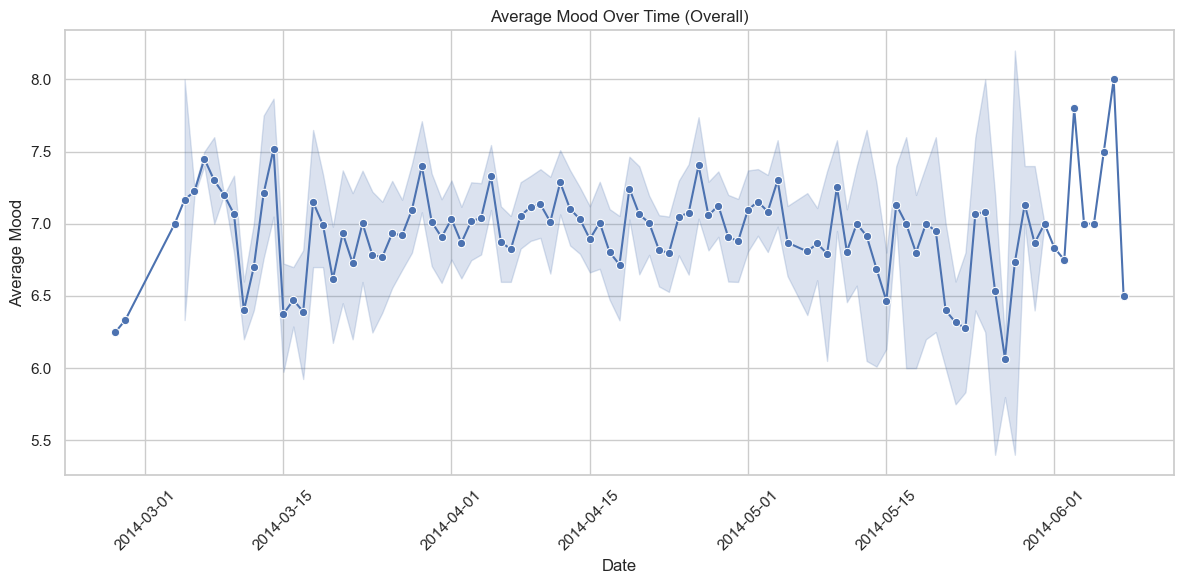

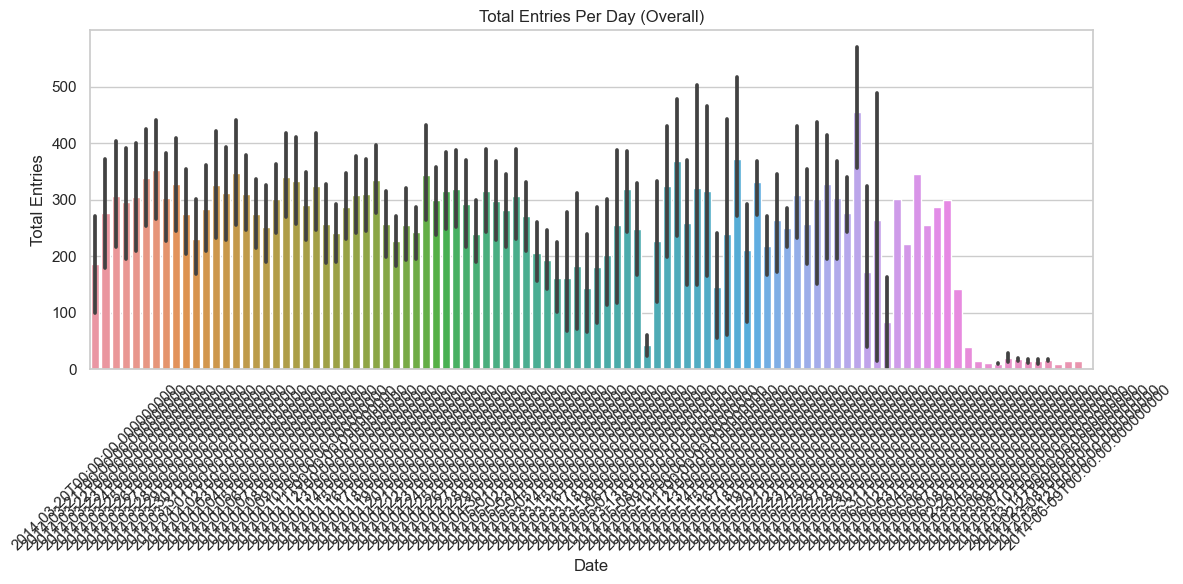

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting the average mood over time for the entire dataset
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_cleaned, x='date', y='mood_avg', marker='o')
plt.title('Average Mood Over Time (Overall)')
plt.xlabel('Date')
plt.ylabel('Average Mood')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the total entries per day for the entire dataset
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_cleaned, x='date', y='total_entries')
plt.title('Total Entries Per Day (Overall)')
plt.xlabel('Date')
plt.ylabel('Total Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# ---------------------------
# 1) Assume you already have your daily_cleaned DataFrame loaded
#    Its structure should be similar to:
#         id        date  mood  activity  circumplex.arousal  ...  mood_avg  mood_var  mood_count  total_entries  weekday
# 0   AS14.01  2014-02-26  25.0  0.000000                -1.0  ...  6.250000   0.250000         4.0             12      2.0
# 1   AS14.01  2014-02-27  19.0  0.000000                 0.0  ...  6.333333   0.333333         3.0              9      3.0
# ...
#
# Replace the file path as needed if you need to load it:
# daily_cleaned = pd.read_csv('your_daily_cleaned_file.csv')

# For this example, we assume daily_cleaned already exists.

# ---------------------------
# 2) Replace id with a numeric user_id by parsing the trailing digits
# ---------------------------
def parse_last_digits(as_id: str):
    """
    Convert a string like "AS14.07" to an integer 7.
    Assumes the user ID format is consistent with a dot separating the prefix and the trailing number.
    """
    return int(as_id.split('.')[-1])

# Create a new column "user_id" using the parsing function.
daily_cleaned['user_id'] = daily_cleaned['id'].apply(parse_last_digits)
print(daily_cleaned['user_id'])

# ---------------------------
# 3) Select numeric columns for KNN imputation
# ---------------------------
# We want to impute missing mood-related values.
# Here is a list of numeric columns we consider (adjust as needed):
numeric_cols = [
    'user_id',                # our new numeric user identifier
    'mood',                   # raw mood (if applicable)
    'activity',
    'circumplex.arousal',
    'circumplex.valence',
    'screen',
    'call',
    'sms',
    'appCat.builtin',
    'appCat.communication',
    'appCat.entertainment',
    'appCat.finance',
    'appCat.game',
    'appCat.office',
    'appCat.other',
    'appCat.social',
    'appCat.travel',
    'appCat.unknown',
    'appCat.utilities',
    'appCat.weather',
    'mood_avg',
    'mood_var',
    'mood_count',
    'total_entries',
    'weekday'
]

# Ensure that only columns present in the DataFrame are used.
numeric_cols = [col for col in numeric_cols if col in daily_cleaned.columns]
print("Columns used for KNN imputation:", numeric_cols)

# ---------------------------
# 4) Create a copy of the DataFrame for imputation
# ---------------------------
daily_knn = daily_cleaned.copy()

# ---------------------------
# 5) Extract numeric data and apply KNNImputer
# ---------------------------
X = daily_knn[numeric_cols]

imputer = KNNImputer(n_neighbors=5, weights='uniform')  # You can adjust n_neighbors as needed
X_imputed = imputer.fit_transform(X)

# Put the imputed data back into our DataFrame
daily_knn[numeric_cols] = X_imputed

# ---------------------------
# 6) Verify that missing values have been imputed
# ---------------------------
print("Missing values per numeric column AFTER KNN imputation:")
print(daily_knn[numeric_cols].isnull().sum())

# (Optional) Save the imputed DataFrame to a CSV file
# daily_knn.to_csv('daily_knn_imputed.csv', index=False)

0        1
1        1
2        1
3        1
4        1
        ..
1968    31
1969    31
1970    33
1971     3
1972    24
Name: user_id, Length: 1309, dtype: int64
Columns used for KNN imputation: ['user_id', 'mood', 'activity', 'circumplex.arousal', 'circumplex.valence', 'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'mood_avg', 'mood_var', 'mood_count', 'total_entries', 'weekday']
Missing values per numeric column AFTER KNN imputation:
user_id                 0
mood                    0
activity                0
circumplex.arousal      0
circumplex.valence      0
screen                  0
call                    0
sms                     0
appCat.builtin          0
appCat.communication    0
appCat.entertainment    0
appCat.finance          0
appCat.game             0
appCat.office        

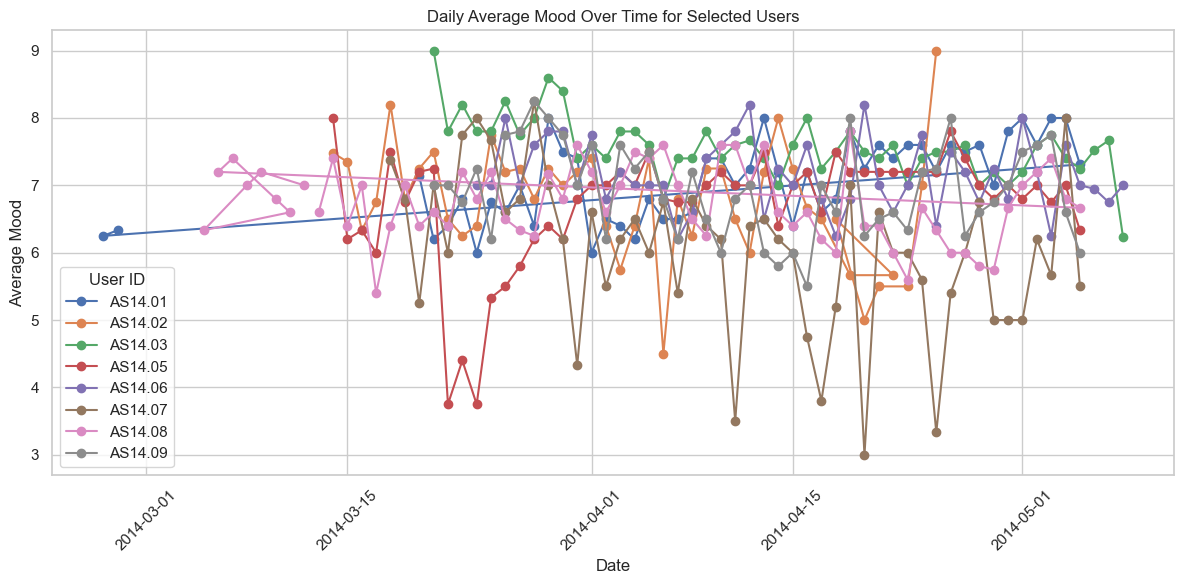

In [9]:
import matplotlib.pyplot as plt

# Example: Plot daily average mood over time for one or a few users
user_list = daily_knn['id'].unique()[:8]  # Plot for the first 3 users for clarity

plt.figure(figsize=(12, 6))
for user in user_list:
    user_data = daily_knn[daily_knn['id'] == user]
    plt.plot(user_data['date'], user_data['mood_avg'], marker='o', label=user)
plt.xlabel('Date')
plt.ylabel('Average Mood')
plt.title('Daily Average Mood Over Time for Selected Users')
plt.xticks(rotation=45)
plt.legend(title='User ID')
plt.tight_layout()
plt.show()

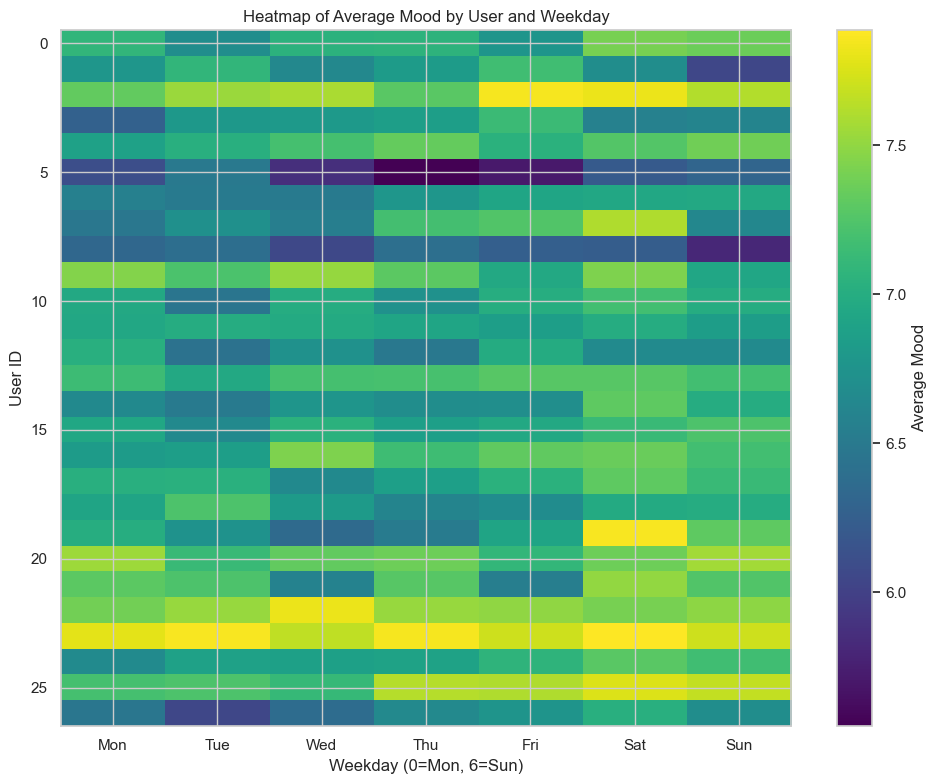

In [10]:
# Pivot to get users as rows and weekday as columns, with average mood values
pivot = daily_knn.pivot_table(index='id', columns='weekday', values='mood_avg', aggfunc='mean')

plt.figure(figsize=(10, 8))
plt.imshow(pivot, aspect='auto', cmap='viridis')
plt.colorbar(label='Average Mood')
plt.xlabel('Weekday (0=Mon, 6=Sun)')
plt.ylabel('User ID')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Heatmap of Average Mood by User and Weekday')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

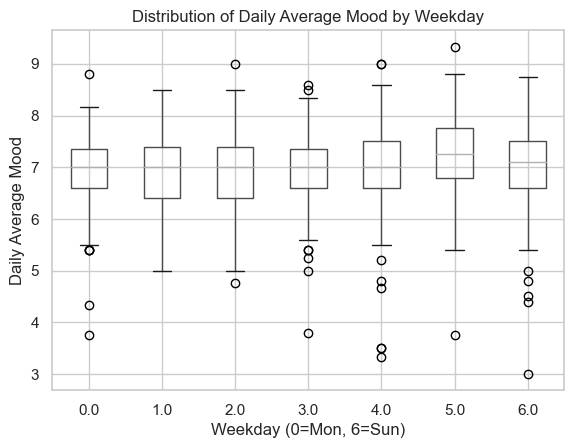

In [11]:
plt.figure(figsize=(10, 6))
daily_knn.boxplot(column='mood_avg', by='weekday')
plt.xlabel('Weekday (0=Mon, 6=Sun)')
plt.ylabel('Daily Average Mood')
plt.title('Distribution of Daily Average Mood by Weekday')
plt.suptitle('')
plt.show()

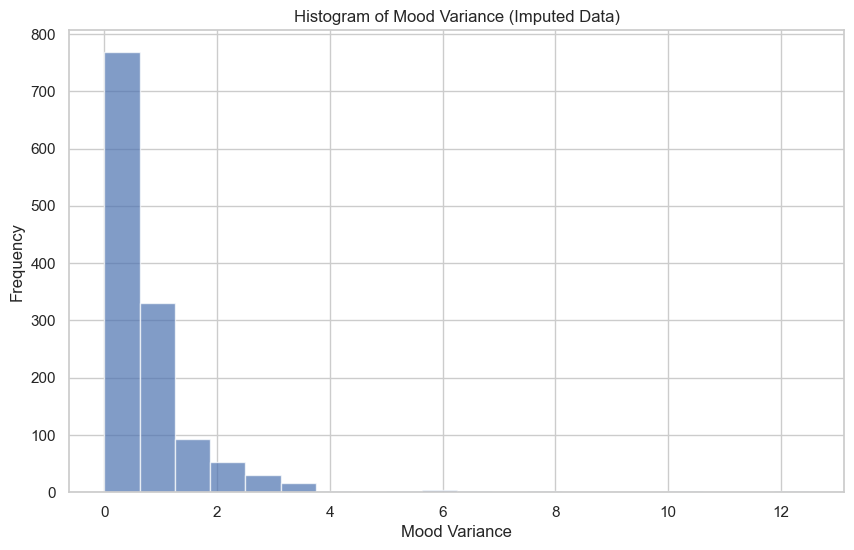

In [12]:
plt.figure(figsize=(10, 6))
daily_knn['mood_var'].plot(kind='hist', bins=20, alpha=0.7)
plt.xlabel('Mood Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Mood Variance (Imputed Data)')
plt.show()

All numeric columns: Index(['screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'mood',
       'activity', 'circumplex.arousal', 'circumplex.valence', 'mood_avg',
       'mood_var', 'mood_count', 'total_entries', 'weekday', 'user_id'],
      dtype='object')


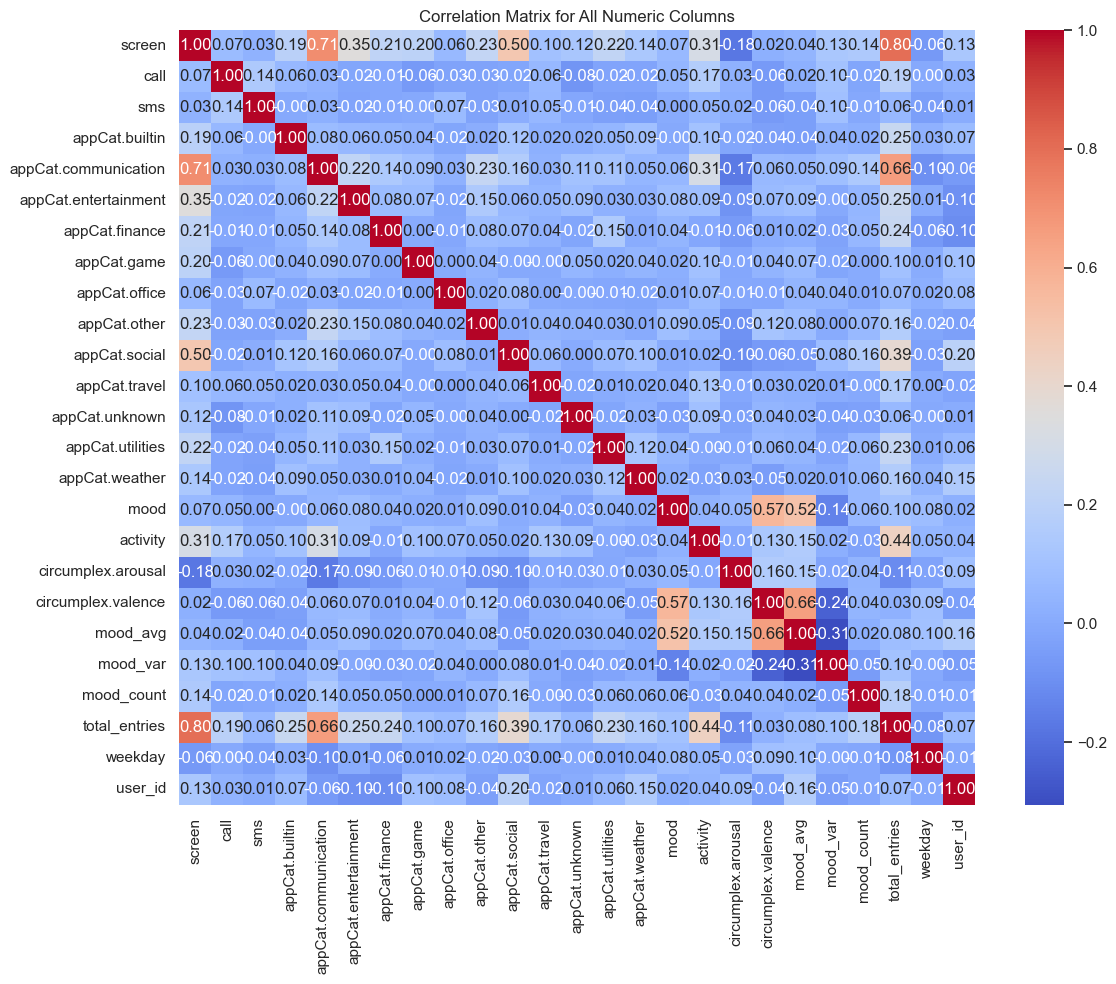

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Select all numeric columns from daily_knn
numeric_cols = daily_knn.select_dtypes(include=[np.number]).columns
print("All numeric columns:", numeric_cols)

# 2) Compute the correlation matrix for these columns
corr_matrix = daily_knn[numeric_cols].corr()

# 3) Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for All Numeric Columns")
plt.tight_layout()
plt.show()

In [14]:
daily_knn[numeric_cols].nunique()

screen                  1206
call                      22
sms                       17
appCat.builtin          1193
appCat.communication    1184
appCat.entertainment     850
appCat.finance           208
appCat.game              192
appCat.office            275
appCat.other            1118
appCat.social            988
appCat.travel            427
appCat.unknown           264
appCat.utilities         425
appCat.weather           113
mood                      60
activity                1161
circumplex.arousal        42
circumplex.valence        30
mood_avg                  91
mood_var                 187
mood_count                16
total_entries            555
weekday                    7
user_id                   27
dtype: int64

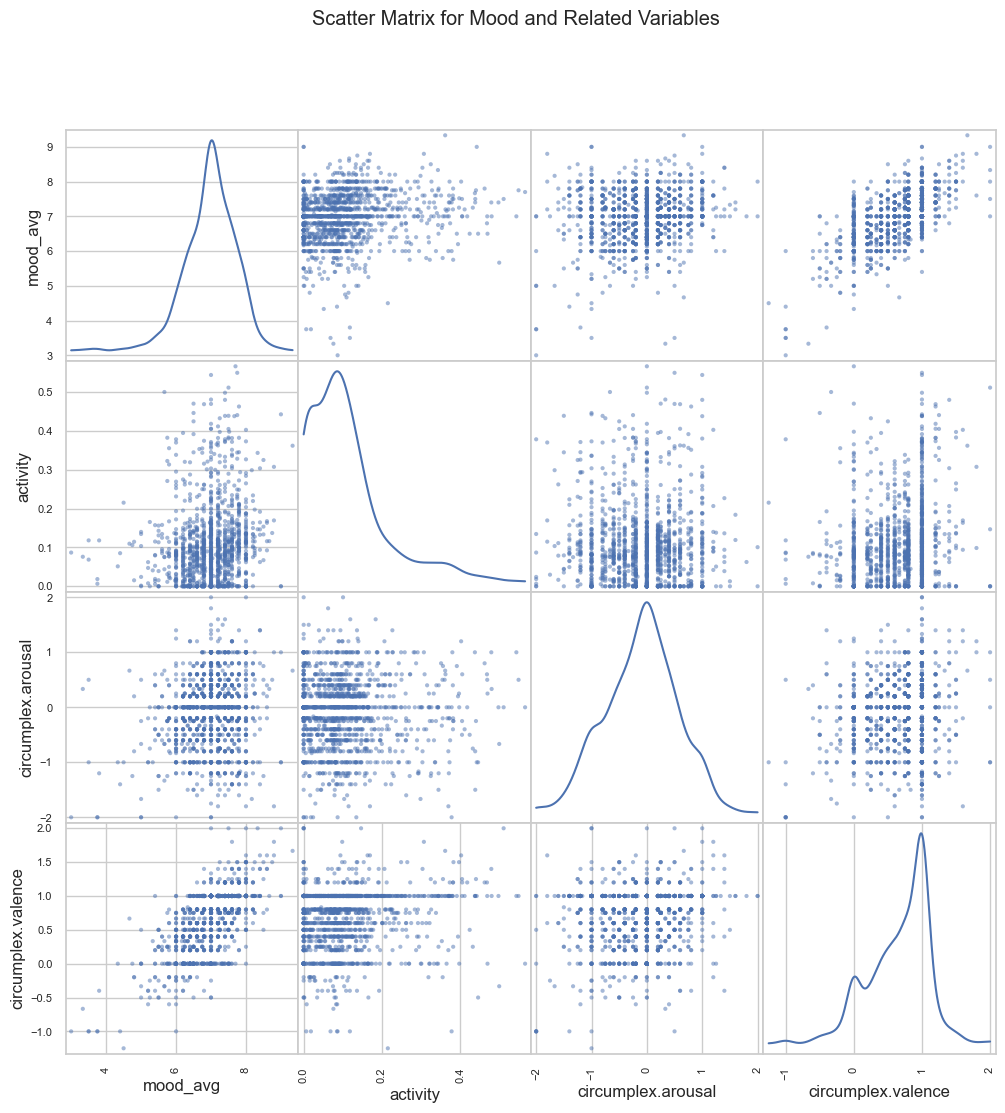

In [15]:
from pandas.plotting import scatter_matrix

scatter_cols = ['mood_avg', 'activity', 'circumplex.arousal', 'circumplex.valence']
scatter_matrix(daily_knn[scatter_cols], figsize=(12, 12), diagonal='kde')
plt.suptitle('Scatter Matrix for Mood and Related Variables')
plt.show()

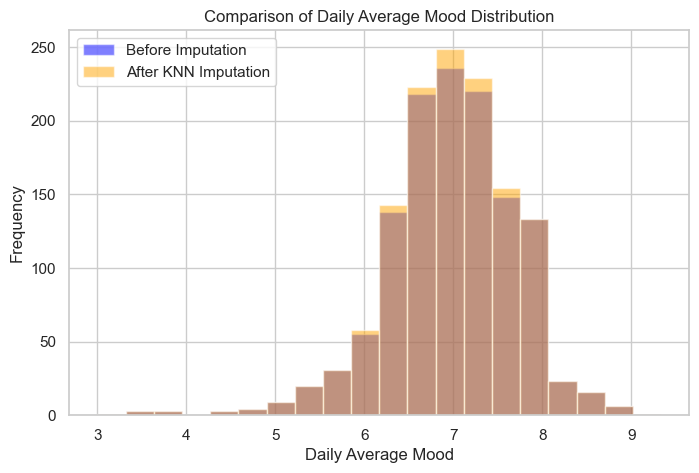

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(
    daily_cleaned['mood_avg'].dropna(), bins=20, alpha=0.5,
    color='blue', label='Before Imputation'
)
plt.hist(
    daily_knn['mood_avg'], bins=20, alpha=0.5,
    color='orange', label='After KNN Imputation'
)
plt.xlabel('Daily Average Mood')
plt.ylabel('Frequency')
plt.title('Comparison of Daily Average Mood Distribution')
plt.legend()
plt.show()

--------------------------------------------------------------------------------MOVING AVERAGE-------------------------------------------------------------------------------------------------------

In [17]:
import numpy as np
import pandas as pd

# Create a copy to work on moving average imputation across all numeric columns
daily_mov_avg = daily_cleaned.copy()

# Convert 'date' to datetime and sort by 'id' and 'date'
daily_mov_avg['date'] = pd.to_datetime(daily_mov_avg['date'])
daily_mov_avg = daily_mov_avg.sort_values(by=['id', 'date'])

# Select all numeric columns in the DataFrame
all_numeric_cols = daily_mov_avg.select_dtypes(include=[np.number]).columns
print("All numeric columns:", all_numeric_cols.tolist())

# Define columns to exclude from imputation (e.g., 'id', 'user_id')
exclude_cols = ['id', 'user_id']  # adjust as needed

# Create a list of numeric columns that we want to impute
cols_to_impute = [col for col in all_numeric_cols if col not in exclude_cols]
print("Columns to impute using moving average:", cols_to_impute)

# Loop over each column and apply moving average imputation per user
for col in cols_to_impute:
    # Use a rolling window (set to 7 here) to compute the mean for filling NaNs
    daily_mov_avg[col] = daily_mov_avg.groupby('id')[col].apply(
        lambda group: group.fillna(group.rolling(window=7, min_periods=1, center=True).mean())
    )
    # Chain forward fill then backward fill for any remaining NaNs
    daily_mov_avg[col] = daily_mov_avg.groupby('id')[col].apply(
        lambda group: group.fillna(method='ffill').fillna(method='bfill')
    )

# Print the missing values per numeric column after imputation
print("Missing values per numeric column AFTER moving average imputation on all columns:")
print(daily_mov_avg.isna().sum())

# Optional: Save the updated DataFrame to a CSV file
# daily_mov_avg.to_csv('daily_mov_avg.csv', index=False)


All numeric columns: ['screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'mood', 'activity', 'circumplex.arousal', 'circumplex.valence', 'mood_avg', 'mood_var', 'mood_count', 'total_entries', 'weekday', 'user_id']
Columns to impute using moving average: ['screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'mood', 'activity', 'circumplex.arousal', 'circumplex.valence', 'mood_avg', 'mood_var', 'mood_count', 'total_entries', 'weekday']
Missing values per numeric column AFTER moving average imputation on all columns:
id                      0
date                    0
screen                  0
call        

/var/folders/1b/g9y0xvbx5xjdnjj492r4x4tc0000gn/T/ipykernel_46145/49403505.py:25: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  daily_mov_avg[col] = daily_mov_avg.groupby('id')[col].apply(
/var/folders/1b/g9y0xvbx5xjdnjj492r4x4tc0000gn/T/ipykernel_46145/49403505.py:29: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., 

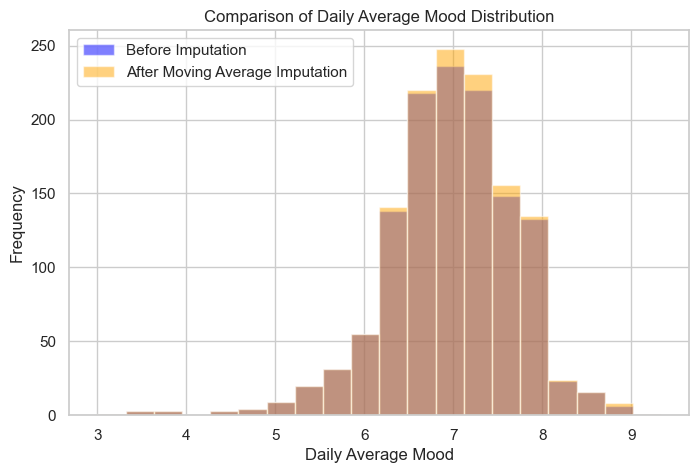

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(
    daily_cleaned['mood_avg'].dropna(), bins=20, alpha=0.5,
    color='blue', label='Before Imputation'
)
plt.hist(
    daily_mov_avg['mood_avg'].dropna(), bins=20, alpha=0.5,
    color='orange', label='After Moving Average Imputation'
)
plt.xlabel('Daily Average Mood')
plt.ylabel('Frequency')
plt.title('Comparison of Daily Average Mood Distribution')
plt.legend()
plt.show()

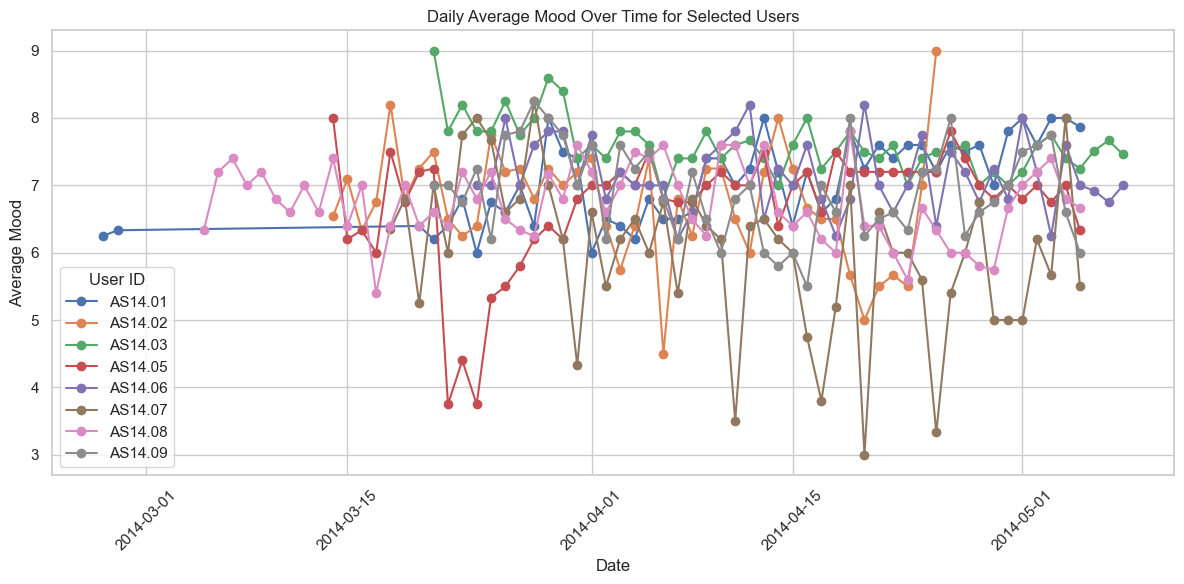

In [20]:
import matplotlib.pyplot as plt

# Example: Plot daily average mood over time for one or a few users
user_list = daily_mov_avg['id'].unique()[:8]

plt.figure(figsize=(12, 6))
for user in user_list:
    user_data = daily_mov_avg[daily_mov_avg['id'] == user]
    plt.plot(user_data['date'], user_data['mood_avg'], marker='o', label=user)
plt.xlabel('Date')
plt.ylabel('Average Mood')
plt.title('Daily Average Mood Over Time for Selected Users')
plt.xticks(rotation=45)
plt.legend(title='User ID')
plt.tight_layout()
plt.show()

All numeric columns: Index(['screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'mood',
       'activity', 'circumplex.arousal', 'circumplex.valence', 'mood_avg',
       'mood_var', 'mood_count', 'total_entries', 'weekday', 'user_id'],
      dtype='object')


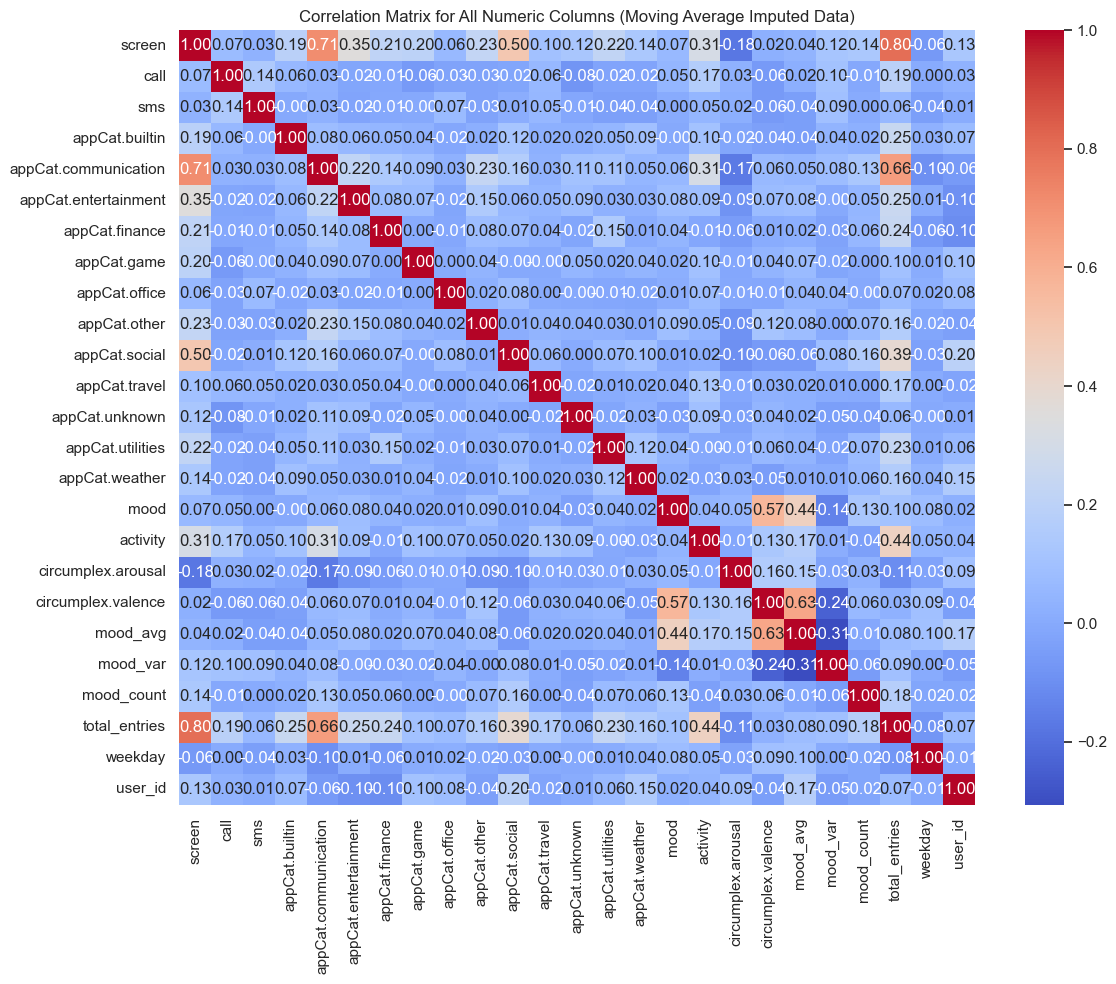

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Select all numeric columns from daily_mov_avg
numeric_cols = daily_mov_avg.select_dtypes(include=[np.number]).columns
print("All numeric columns:", numeric_cols)

# 2) Compute the correlation matrix for these columns
corr_matrix = daily_mov_avg[numeric_cols].corr()

# 3) Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for All Numeric Columns (Moving Average Imputed Data)")
plt.tight_layout()
plt.show()
